In [ ]:
### 只做单模型，其他的内容，等等再说，现在把单模型的表现提升上去再说,这份code的目标只是为了提升模型的分类效率

In [16]:
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn import metrics
import datetime

import model_ml as mm
import feat_engineering as fe
import feat_selection as fs
import model_tunning as mt
from param_config import config

In [17]:
dfTrain = pd.read_csv(config.original_train_data_path)
dfPred = pd.read_csv(config.original_pred_data_path)
predictors = dfPred.columns.tolist()[4:]
check_missing = ['PartI_1','PartII_1','PartIII_1','PartIV_1','PartV_1','PartVI_1']


###清理异常Y值
dfTrain = dfTrain.loc[dfTrain['Y']<dfTrain['Y'].max()]
dfTrain = dfTrain.reset_index(drop=True)

dfTrain.loc[dfTrain['Y']>dfTrain['Y'].quantile(0.9),'Y'] = 1
dfTrain.loc[dfTrain['Y']!=1,'Y'] = 0

In [18]:
def FeatAll(train,pred):
    dfAll = pd.concat([train,pred])
    dfAll = dfAll.reset_index(drop=True)
    dfAll['date'] = (pd.to_datetime(dfAll['date']) - parse('2017-10-09')).dt.days

    ###这个部分将每一列分箱，并且计算基于该列分类的其他列的百分比顺序，目前看来没啥用
    var_dict = {}
    for colBase in predictors+['sex','age']:
        if dfAll[colBase].nunique()<=5:
            var_dict[colBase] = [x for x in predictors if x!=colBase]
        else:
            dfAll[colBase+'_based'] = pd.cut(dfAll[colBase],bins=5,labels=[colBase+'_bin_%d'%i for i in range(5)])
            dfAll[colBase+'_based'] = dfAll[colBase+'_based'].astype(str)
            dfAll[colBase+'_based'].fillna(colBase+'_bin_NA',inplace = True)
            var_dict[colBase+'_based'] = [x for x in predictors if x!=colBase]
    #dfAllPcentByOther = fe.pcent_by_other_col(dfAll,var_dict,['ID']) 
    #dfAllPcentByOther = pd.read_csv('../../Cache/pcent_by_other.csv')
    
    for var in dfAll.columns:
        if '_based' in var:
            del dfAll[var]
            
    ###根据日期放置一个百分比顺序作为尝试
    dfAllPcentByDate = fe.pcent_by_other_col(dfAll,{'date':predictors},['ID']) 
    
    '''dfAll['date'] = pd.qcut(dfAll['date'],q=10,labels=['date_bin_%d'%i for i in range(10)])
    dfAll = pd.concat([dfAll,pd.get_dummies(dfAll['date'])],axis=1)'''
    ###目前不想使用日期，觉得用处不大
    del dfAll['date']

    #for minus in 
    
    for ratio in [['PartIII_3','PartI_5'],['PartIII_1','PartI_5'],['PartI_6','PartI_5'],['PartI_7','PartI_5'],['PartII_3','PartII_2'],['PartII_4','PartII_2'],['PartV_2','PartV_1'],['PartII_1','PartII_2']]:
        dfAll[ratio[0]+'_divided_'+ratio[1]] = dfAll[ratio[0]]/dfAll[ratio[1]]
        
    for multiply in [['PartV_1','PartV_9'],['PartV_1','PartV_10'],['PartV_1','PartV_11'],['PartV_1','PartV_12'],['PartV_1','PartV_13']]:
        dfAll[multiply[0]+'_multiply_'+multiply[1]] = dfAll[multiply[0]]*dfAll[multiply[1]]
    
    
    ###看看missing 的情况
    dfAll['missing_cnt'] = dfAll[check_missing].isnull().sum(axis=1)
    for i in range(len(check_missing)):
        dfAll['missing_part%d'%i] = dfAll[check_missing[i]].isnull().astype(int)
    
    
    for key,group in {'PartI':['PartI_1','PartI_2','PartI_3','PartI_4'],'PartII':['PartII_1','PartII_3','PartII_4']}.items():
        dfAll['group_'+key+'_std'] = dfAll[group].std(axis=1)
        dfAll['group_'+key+'_mean'] = dfAll[group].mean(axis=1)
        dfAll['group_'+key+'_median'] = dfAll[group].median(axis=1)
    
    #dfAll = dfAll.merge(dfAllPcentByOther,'inner','ID')
    dfAll = dfAll.merge(dfAllPcentByDate,'inner','ID')
    
    
    dfTrain = dfAll.loc[dfAll['ID'].isin(train['ID'])]
    dfPred = dfAll.loc[dfAll['ID'].isin(pred['ID'])]
    
    return dfTrain,dfPred,var_dict

In [19]:
dfTrain,dfPred,var_dict = FeatAll(dfTrain,dfPred)
predictors = dfPred.columns.tolist()
predictors.remove('ID')
predictors.remove('Y')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
len(predictors)

100

In [21]:
params = {'max_depth':5, 'eta':0.01, 'silent':0,'objective':'binary:logistic','lambda':1,'subsample':0.8,'colsample_bytree':0.8,'eval_metric':'logloss'}

In [22]:
dfTrain =dfTrain.fillna(dfTrain.median())

In [23]:
n_splits=5
early_stop=50
test_result,result,imp = mm.xgb_kfold(dfTrain,dfPred,predictors,n_splits,early_stop = early_stop,params=params)

[0]	train-logloss:0.686044	eval-logloss:0.686498
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.33545	eval-logloss:0.374219
[200]	train-logloss:0.23193	eval-logloss:0.299822
[300]	train-logloss:0.188044	eval-logloss:0.278813
[400]	train-logloss:0.162677	eval-logloss:0.271918
[500]	train-logloss:0.144812	eval-logloss:0.270212
[600]	train-logloss:0.130425	eval-logloss:0.26963
Stopping. Best iteration:
[579]	train-logloss:0.133311	eval-logloss:0.269433

Best tree is 580, performance is 0.133311, 0.269433
[0]	train-logloss:0.686115	eval-logloss:0.686492
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.336883	eval-logloss:0.3699
[200]	train-logloss:0.232646	eval-logloss:0.294691
[300]	train-logloss:0.18804	eval-logloss:0.273266
[400]	train-logloss:0

KS=0.507, AUC=0.83, N=5641
At threshold=0.099, TPR=0.41, 230 out of 557
At threshold=0.099, FPR=0.06, 324 out of 5084
Ave_target: [ 0.10283688  0.09929078  0.10638298  0.10283688  0.09042553  0.09751773
  0.10106383  0.10106383  0.09929078  0.08687943]
Ave_predicted: [ 0.09556763  0.0822185   0.09111805  0.08763051  0.08701553  0.08243312
  0.08332517  0.09150099  0.09602523  0.08396251]
plot


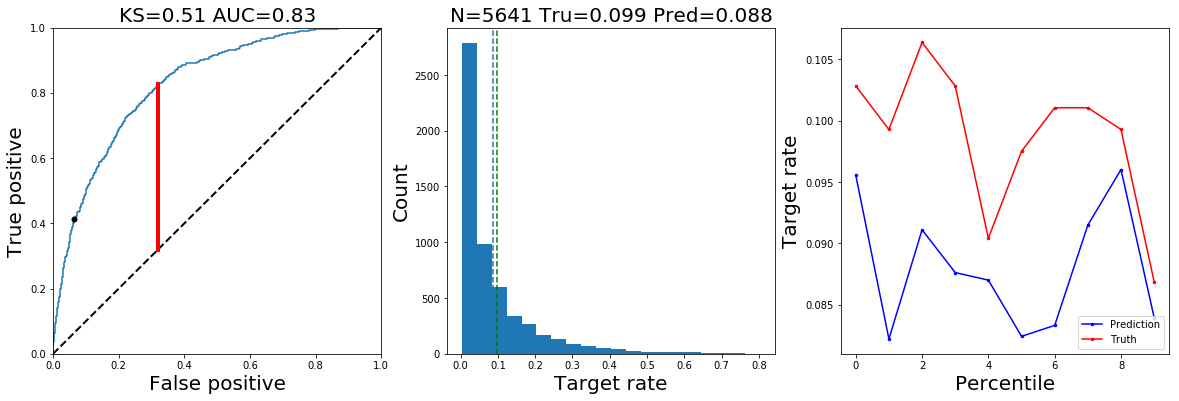

0.5066159613643394

In [24]:
mt.evaluate_performance(test_result['target'],test_result['score'])

In [25]:
for i in range(1,n_splits+1):
    imp['imp_fold%d'%i] = imp['imp_fold%d'%i]/imp['imp_fold%d'%i].sum()
imp['sum_imp'] = imp[['imp_fold%d'%i for i in range(1,n_splits+1)]].sum(axis=1)

In [26]:
imp.sort_values('sum_imp',ascending=False)
tmpPredictor = imp.sort_values('sum_imp',ascending=False)['variable'].values.tolist()[0:40]

In [27]:
test_result,result,imp = mm.xgb_kfold(dfTrain,dfPred,tmpPredictor,n_splits,early_stop = early_stop,params=params)

[0]	train-logloss:0.686204	eval-logloss:0.686526
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.337278	eval-logloss:0.373547
[200]	train-logloss:0.235438	eval-logloss:0.298858
[300]	train-logloss:0.193045	eval-logloss:0.277523
[400]	train-logloss:0.168926	eval-logloss:0.271132
[500]	train-logloss:0.151174	eval-logloss:0.268417
[600]	train-logloss:0.136918	eval-logloss:0.267576
Stopping. Best iteration:
[563]	train-logloss:0.142131	eval-logloss:0.267345

Best tree is 564, performance is 0.142131, 0.267345
[0]	train-logloss:0.686147	eval-logloss:0.68658
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.338374	eval-logloss:0.369494
[200]	train-logloss:0.235855	eval-logloss:0.294285
[300]	train-logloss:0.192832	eval-logloss:0.272324
[400]	train-logl

KS=0.506, AUC=0.83, N=5641
At threshold=0.099, TPR=0.43, 238 out of 557
At threshold=0.099, FPR=0.06, 317 out of 5084
Ave_target: [ 0.10638298  0.09929078  0.10460993  0.09397163  0.09751773  0.09929078
  0.10638298  0.10638298  0.07978723  0.09397163]
Ave_predicted: [ 0.09860472  0.07841559  0.09250881  0.08317348  0.09206604  0.08191443
  0.08731648  0.08982547  0.09682878  0.08620339]
plot


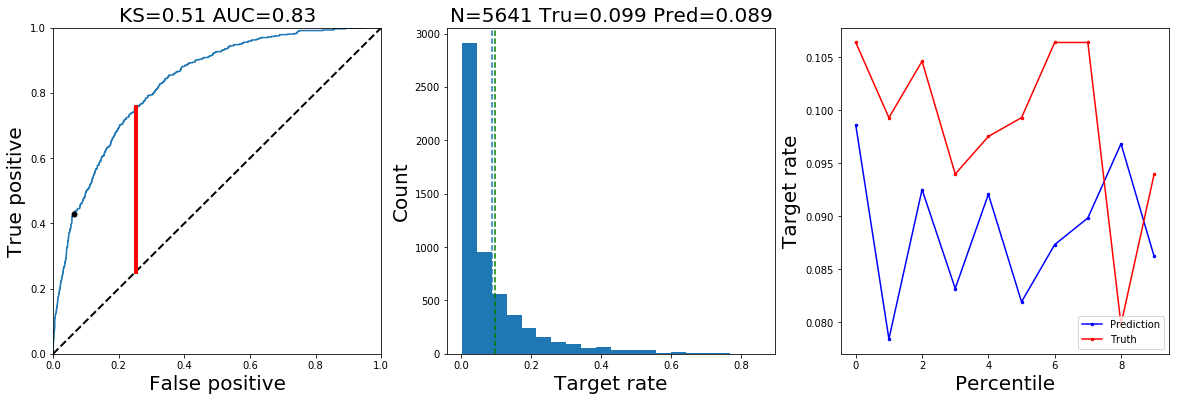

0.50605659745715426

In [15]:
mt.evaluate_performance(test_result['target'],test_result['score'])

In [ ]:
n_splits=5
other_note ='_sick_test'
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
submit = result[['ID','score']]
today = datetime.date.today().strftime('%Y-%m-%d')
result.to_csv('../../Submission/result/result_%s'%today+other_note+'.csv',index=False)
submit['score'].to_csv('../../Submission/submit_%s'%today+other_note+'.csv',header=False,index=False)
test_result.to_csv('../../Submission/test/test_result_%s'%today+other_note+'.csv',index=False)
imp.to_csv('../../Submission/imp/importance_%s'%today+other_note+'.csv',index=False)

In [ ]:
###基础变量
1.83977998784

###增加部分比例数据，已经缺失体检项目情况
1.84295123211  imp来看，missing信息没有意义

###上一版去除missing
1.83839589522



###增加一些比值信息
1.84354856365


###根据日期的百分比，效果更加不好了
1.85046680299  变量选择之后 1.83862284729


###前面所有的特征
1.86013896413   变量选择之后  1.85446185976